In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10.0,8.0]
def idm(dim,width=0):
    M1 = np.tri(dim,dim,width)
    M2 = np.tri(dim,dim,-width-1)
    M3 = np.ones([dim,dim])
    M4 = M3 - M2
    M5 = np.multiply(M1,M4)
    return M5


# Original PAPC
PAPC is designed to solve a minmax problem, i.e. finding a saddle point for problems of the form:
$$ \min_u \max_v \{K(u,v)\} = \min_u \max_v \left\{f(u) + \left<M^Tu,v\right> - g(v)\right\} $$
Where:
* $f$ has a $L_f$ lipshitz gradient
* $g$ is LSC not 
* Both are convex, proper 

### PAPC
* $p^{k+1} = u^k -\tau\left(Mv^k+\nabla f(u^k)\right)$
* $v^{k+1} = prox_{g,\sigma}\left(v^k+\frac{1}{\sigma}M^T p^{k+1}\right)$
* $u^{k+1} = u^k -\tau\left(Mv^{k+1}+\nabla f(u^k)\right)$

### Convergence
A point $\left(\tilde(u),\tilde{v}\right)$ is a saddle point of K if $\forall u,v \quad K(\tilde{u},v)\leq K(\tilde{u},\tilde{v}) \leq K(u,\tilde{v})$

A point $\left(\tilde(u),\tilde{v}\right)$ is a $\varepsilon$-saddle point of K if $\forall u \quad K(\tilde{u},v)-\varepsilon\leq K(\tilde{u},\tilde{v}) \leq K(u,\tilde{v})+\varepsilon$

Note that any point $\left(\tilde{u},\tilde{v}\right)$ which hold $\forall u,v \quad K\left(\tilde{u},v\right)-K\left(u,\tilde{v}\right)\leq\varepsilon$ is a $\varepsilon$-saddle point of K.

[DST15] Theorem 3.1: Let $\left\{\left(p^k,v^k,u^k\right)\right\}_{k\in\mathbb{N}}$ be the sequence generated by the PAPC algorithm with $\tau L_f\leq 1$ and $\tau\sigma\lVert M^TM\rVert\leq 1$. Then $G:=\sigma I -\tau M^TM$ is positive semidefinite and for every $u,v$ we have $$K\left(\bar{u}^N,v\right)-K\left(u,\bar{v}^N\right)\leq\frac{\tau^-1\left\lVert u-u^0\right\rVert^2+\left\lVert v-v^0\right\rVert_G^2}{2N}$$

## ALMA & PAPC - the underlying PG term

### Dual Problem
Consider the dual problem 
$$\max_v\min_u\left\{f(u)+\left<M^Tu,v\right>-g(v)\right\}$$ 
$$=\max_v\left\{-g(v)-\max_u\left\{\left<u,-Mv\right> - f(u)\right\}\right\}$$ 
$$=\max_v\left\{-g(v)-f^*(-Mv)\right\}$$
$$=-\min_v\left\{g(v)+f^*(-Mv)\right\}$$
We drop the sign because we are interested in the argmin and get:
$$\text{(DM1)}\quad\min_v\left\{g(v)+f^*(w)\mid Mv+w=0\right\}$$

### Lagrangian
* The lagrngian is $L(w,v,c)=f^*(w)+g(v)-\left<c,Mv+w\right>$
* And the augmented lagrangian: $L_t(w,v,c)=f^*(w)+g(v)-\left<c,Mv+w\right>+\frac{t}{2}\lVert Mv+w \rVert ^2$

### ALMA
* $w^{k+1}\in\arg\min_w L(w,v^k,c^k) = \arg\min_w\left\{f^*(w)-<c^k,w>\right\}$
* $v^{k+1}\in\arg\min_v L_t(w^{k+1},v,c^k)=\arg\min_v\left\{g(v)-\left<c^k,Mv\right>+\frac{t}{2}\lVert Mv+w^{k+1} \rVert^2 \right\}$
* $c^{k+1}=c^k-t\left(Mv^{k+1}+w^{k+1}\right)$

#### From ALMA to PAPC
We first note that $w^{k+1}=\nabla f(c^k)$. This is because:
1. From 1st order optimality condition :$0\in \partial f^*(w^{k+1})-c^k$
2. [why?] This imply that $\partial w^{k+1} \in f^{**}(c^k)$
3. Since $f$ is LSC, $f^{**}=f$
4. $f$ is Lipschitz so smooth, hence $\partial f = \nabla f$

Thus ALMA can be rewritten for this case as:
* $v^{k+1}\in\arg\min_v\{g(v)-<c^k,Mv>+\frac{t}{2}\lVert Mv+\nabla f(c^k) \rVert^2 \}$
* $c^{k+1}=c^k-t(Mv^{k+1}+\nabla f(c^k))$

In this reduced formulation, the first part, namely finding $v^{k+1}$, might be hard to compute exactly. It is possible to ease the effort by finding an approximate solution. This can be done using the Proximal Gradient (PG) method:

1. define $P_k(v)=\frac{\tau}{2}\lVert Mv +\nabla f(c^k) -\frac{1}{\tau}c^k\rVert^2$
2. note that $v^{k+1}=\arg\min_v\{g(v)+P_k(v)\}$ since the difference is in non $v$ terms
3. use PG on this new formulation:
    1. $v^{k+1}=prox_{g,\sigma}(v^k-\frac{1}{\sigma}(\nabla_v P_k(v^k))$
    2. $v^{k+1}=\arg\min_v\{g(v)+\frac{\sigma}{2}\lVert v- (v^k-\frac{1}{\sigma}\nabla_vP_k(v^k))\rVert^2\}$
4. $\nabla_vP_k(v)=\tau M^T (Mv +\nabla f(c^k) -\frac{1}{\tau}c^k)$
5. define $p^{k+1}=c^k-\tau(Mv+\nabla f(c^k))$, so $\nabla_vP_k(v)=-M^Tp^{k+1}$
6. this define the PG step for the approximate $v^{k+1}$ as:
    1. $p^{k+1}=c^k-\tau(Mv+\nabla f(c^k))$
    2. $v^{k+1}=prox_{g,\sigma}(v^k+\frac{1}{\sigma}M^Tp^{k+1})$

**This is exactly PAPC with $u^k = c^k$ !**

The aim of the following work is to capitulate on this observation in order to find better approximations for the $v^k$ phase and thus to accelerate PAPC.

# Case Study
$$ \min_u H(u) := \min_u \{ \lVert Au-b \rVert ^2 + \lVert Mu \rVert_1 \} $$

## MinMax Formulation
$$ \min_u \max_v \{\lVert Au-b \rVert ^2 + <u,M^Tv> -\delta_{B_{\infty,1}} (v)\} $$

Since $\max_y\{<x,y>-\delta_{B_{\infty,1}}(y)\} = \sum_i x_i\times sign(x_i) = \lVert x \rVert_1$

## Functions
* $ f(u) = \lVert Au-b \rVert^2 $
* $ g(v) = \delta_{B_{\infty,1}} $
* $ \left[ prox_{g}\left(x\right)\right]_i = 
\begin{cases}
1, & x_i \ge 1 \\
x_i, & -1 \le x_i \le 1 \\
-1, & x_i \le -1
\end{cases} $

In [2]:
# prox operator
def prox(x):
    x[x>1] = 1
    x[x<-1] = -1
    return x

In [3]:
# total variation matrix
def TV(dim):
    M1 = np.eye(dim-1,dim,0)
    M2 = np.eye(dim-1,dim,1)
    return M1 - M2
# objective
def H(A,b,M):
    def h(u):
        return np.linalg.norm(np.dot(A,u)-b)**2 + np.sum(np.fabs(np.dot(M,u)))
    return h

# Single Prox PAPC implementation

* $ p^{k+1} = u^k -\tau \left(M^T v^k + \nabla f\left(u^k\right)\right) $
* $ v^{k+1} = prox_{g,\sigma}\left(v^k + \frac{1}{\sigma}Mp^{k+1}\right) $
* $ u^{k+1} = u^k -\tau \left(M^T v^{k+1} + \nabla f\left(u^k\right)\right) $

# Multi prox PAPC

In each cycle the multiprox version of PAPC performs several prox-grad steps in order to find a better $v$ in each iteration
Let $L$ be number of prox-grad iteration in each PAPC iteration, then PAPC-MP are of the form:
* $ p^{k+1,l+1} = u^{k}-\tau\left(M^Tv^{k+1,l}+\nabla f\left(u^{k}\right)\right) $ 
    * $1 \le l \le L$:
    * note that on the $l$ index, $p^{k,l}$ changes with $v^{k,l}$ while the $u^k$ terms do not change!
    * $ v^{k+1,0} = v^{k,L} $
* $ v^{k+1,l+1} = prox_{g,\sigma}\left(v^{k+1,l}+\frac{1}{\sigma}Mp^{k+1,l+1}\right) $
* $ u^{k+1} = u^k -\tau \left(M^T v^{k+1,L} + \nabla f\left(u^k\right)\right) $

In [4]:
# multi prox papc implementation
def papc(L,A,b,M,N,u0,v0,t,s,h=[]):
    
    # initialization
    v = v0
    u = u0
    u1 = u
    Mt = np.transpose(M)
    Ab = np.dot(np.transpose(A),b)
    A2 = np.dot(np.transpose(A),A)
    U1 = []
    U  = []
    H1 = []
    H  = []


    # iterations
    for i in range(N):
        for j in range(L):
            p = u-t*(np.dot(Mt,v) + 2*np.dot(A2,u) - 2*Ab )
            a = v + s*np.dot(M,p)
            v = prox(a)
        u = u-t*(np.dot(Mt,v) + 2*np.dot(A2,u) - 2*Ab )
        u1 = (u + i*u1)/(i+1)
        U.append(u)
        U1.append(u1)
        if h!=[]:
            H.append(h(u))
            H1.append(h(u1))
        
    return{'U1':U1,'U':U,'H1':H1,'H':H}

## Simulation

In [54]:
def comparePapcMp(prob_dim,L,N1,N2,plot_iterations,plot_means):
    # create a random problem
    x = np.ones([prob_dim,1])
    A = np.random.rand(prob_dim,prob_dim)
    b = np.dot(A,x) + np.random.randn(prob_dim,1)
    # b is the known vector
    
    # create the Total Variation matrix
    M = TV(prob_dim)
    
    # establish the objective function
    h = H(A,b,M)
    
    # papc preliminaries
    A2 = np.dot(np.transpose(A),A)
    t = 1/(2*np.linalg.norm(A2,2))
    if t > 1:
        t = np.random.rand(1)
    s = t*(np.linalg.norm(M,2))**2
    u0 = np.zeros(b.shape)
    v0 = np.dot(M,u0)
    
    # run papc-sp for N2 iterations to get optimal bound
    res = papc(1,A,b,M,N2,u0,v0,t,s)
    opt = h(res['U1'][N2-1])
    plt.plot((0,N1),(opt,opt),':',label='opt')
    plt.hold(True)
    
    # now run papc-mp for each grad-prox steps in L
    for l in L:
        res = papc(l,A,b,M,N1,u0,v0,t,s,h)
        if plot_iterations:
            plt.plot(res['H'],'-',label=str(l)+', iter.')
            #plt.hold(True)
        if plot_means:
            plt.plot(res['H1'],'--',label=str(l)+', mean')
            #plt.hold(True)
    
    plt.hold(False)
    plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
        


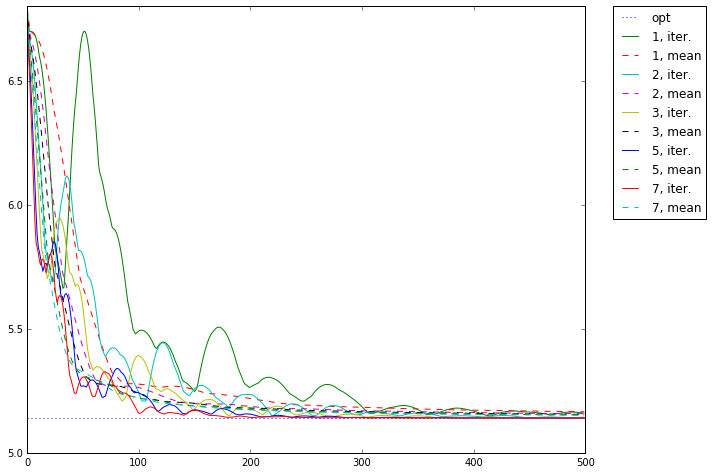

In [63]:
comparePapcMp(10,[1,2,3,5,7],500,100000,True,True)

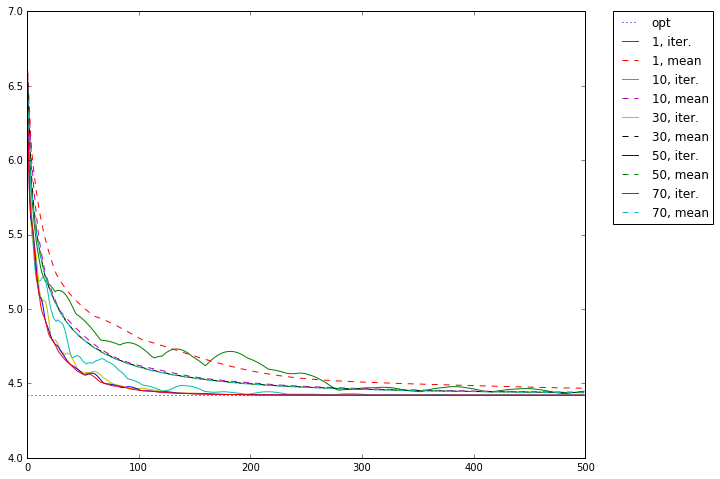

In [64]:
comparePapcMp(10,[1,10,30,50,70],500,100000,True,True)

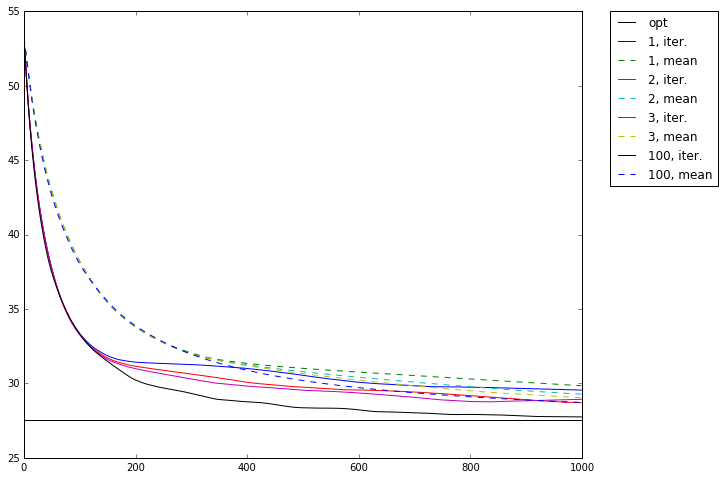

In [47]:
comparePapcMp(50,[1,2,3,100],1000,100000,True,True)

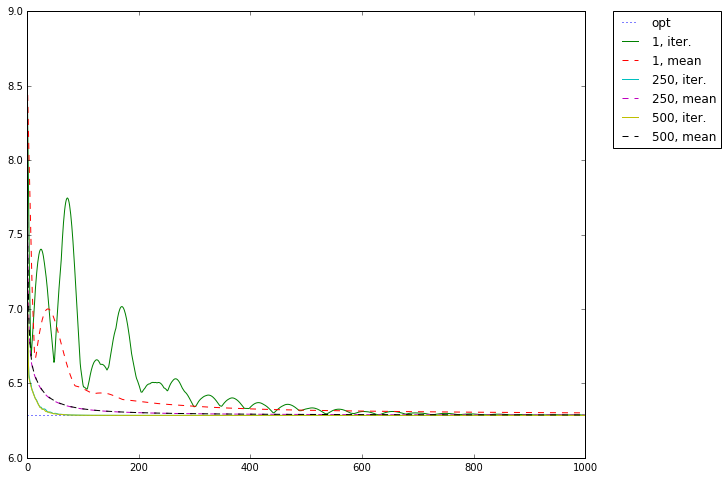

In [60]:
comparePapcMp(10,[1,250,500],1000,100000,True,True)

# Accelerating the prox-grad term

## Bibliography
[DST15] - A simple algorithm for a class of nonsmooth convex–concave saddle-point problems.
Teboulle M, Drori Y, Sabach S. Operation Research Letters 2015

### notes
the generalized fenchel duality (read in mendeley - convex repeated games ...) is for a sum of functions. might be helpful for multi terms versions.